In [1]:
#Import the libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
#NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

finwiz_url = 'https://finviz.com/quote.ashx?t='

## 2. Store the Date, Time and News Headlines Data

The website is FinViz. Notice from the above code that all the news is stored into a table with **id=“news-table”**. I have included two rows of data from the table, bounded by `<tr> </tr>` tags. The code for one of the rows is boxed up. Note the date and **time data** between the first `<td></td>` tags in the box, and the news **headline text** in the `<a></a>` tags. We are going to extract the date, time and news headline for each row and perform sentiment analysis on the news headline.
The code below shows **stores the entire ‘news-table’** from the FinViz website into a Python dictionary, news_tables, for theses stocks — Amazon (AMZN), Tesla (TSLA) and Google(GOOG) (or rather Alphabet, the company that owns Google). You can include as many tickers as you want in the tickers list

In [9]:
news_tables = {}
tickers = ['NOW', 'WISH', 'FFIV', 'SHW']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'})
    response = urlopen(req)
    #read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    #add the table to our dictionary
    news_tables[ticker] = news_table

## 3. Print the Data Stored in news_tables 
To get a sense of what is stored in the news_tables dictionary for ‘AMZN’. Feel free to run the code below, which iterates through each `<tr></tr>` tags (for the first 4 rows) to obtain the headlines between the `<a></a>` tags and the date and time between the `<td></td>` tags before printing them out. This step is optional and is for your own learning.

In [10]:
# # Read one single day of headlines for 'AMZN'

# amzn = news_tables['AMZN']
# # Get all the table rows tagged in HTML with <tr> into amzn_tr
# amzn_tr = amzn.findAll('tr')

# for i, table_row in enumerate(amzn_tr):
#     #read the text of the element 'a' into 'link_text'
#     a_text = table_row.a.text
#     #read the text of the element 'td' into the 'data_text' 
#     td_text = table_row.td.text
#     #print the contents of 'link_text' and 'data_text' 
#     print(a_text)
#     print(td_text)
#     #Exit after printing 4 rows of data 
#     if i==3:
#         break
        

## 4. Parse the Date, Time and News Headlines into a Python List
The following code is similar to the one above, but this time it **parses the date, time and headlines into a Python list** called *parsed_news* instead of printing it out. The if, else loop is necessary because if you look at the news headlines above, only the first news of each day has the ‘date’ label, the rest of the news only has the ‘time’ label so we have to account for this.

In [11]:
parsed_news = []
# Iterate through the news 
for file_name, news_table in news_tables.items():
    #iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        #read the text from each tr tag into text 
        #get text from a only
        text = x.a.get_text()
        # split text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element
        
        if len(date_scrape) == 1:
            time = date_scrape[0]
             
        #else load 'date' as the 1st element and 'time' as the second
        else:
            date = date_scrape[0]
            time = date_scrape[1]
            
        # Extract the ticker from the file name, get the string up to the 1st '_'
        ticker = file_name.split('_')[0]
        
        #append ticker, date, time and headline as a list to the parsed news list 
        parsed_news.append([ticker, date, time, text])

columns = ['ticker', 'date', 'time', 'headline']  
parsed_news = pd.DataFrame(parsed_news, columns=columns)
parsed_news.head()            

,ticker,date,time,headline
0,NOW,Jun-10-21,06:19AM,ServiceNow Rises After Being Added to Goldman'...
1,NOW,Jun-09-21,11:00AM,2 Monstrous Software Stocks That Are on Sale
2,NOW,Jun-03-21,08:17AM,5 Stocks to Watch as Cyberattacks Keep Disrupt...
3,NOW,May-28-21,11:31AM,Why Is ServiceNow (NOW) Down 5.1% Since Last E...
4,NOW,May-27-21,06:57AM,"Do Institutions Own ServiceNow, Inc. (NYSE:NOW..."


## 5. Sentiment Analysis with Vader!
It is now time to perform sentiment analysis with _nltk.sentiment.vader_, finally! We store the ticker, date, time, headlines in a Pandas DataFrame, **perform sentiment analysis on the headlines** before adding an additional column in the DataFrame to store the sentiment scores for each headline.

In [12]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Tatenda
[nltk_data]     Bwerinofa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [13]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names 
columns = ['ticker', 'date', 'time', 'headline']

# convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

#Iterate through the headlines and get the polarity scores using vader 
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).to_list()

#Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

#convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,NOW,2021-06-10,06:19AM,ServiceNow Rises After Being Added to Goldman'...,0.0,1.000,0.000,0.000
1,NOW,2021-06-09,11:00AM,2 Monstrous Software Stocks That Are on Sale,0.0,1.000,0.000,0.000
2,NOW,2021-06-03,08:17AM,5 Stocks to Watch as Cyberattacks Keep Disrupt...,0.0,1.000,0.000,0.000
3,NOW,2021-05-28,11:31AM,Why Is ServiceNow (NOW) Down 5.1% Since Last E...,0.0,1.000,0.000,0.000
4,NOW,2021-05-27,06:57AM,"Do Institutions Own ServiceNow, Inc. (NYSE:NOW...",0.0,0.732,0.268,0.296


## 6. Plot a Bar Chart of the Sentiment Score for Each Day
The following code takes the **average of the sentiment scores** for all news headlines collected during **each date** and **plots it on a bar chart**. You can average the scores for each week too, to obtain the overall sentiment for a week.

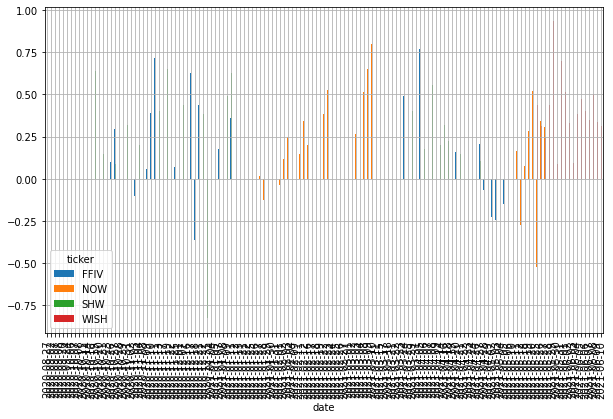

In [14]:
plt.rcParams['figure.figsize'] = [10,6]

#group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker', 'date']).mean()

# unstack the column ticker 
mean_scores = mean_scores.unstack()

# get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis='columns').transpose()

#plot a bar chart with pandas 
mean_scores.plot(kind = 'bar')
plt.grid()